## Apliying Layer-Wise Relevance (LRP) on a Convolutional Neural Network (CNN)

In [2]:
#Importing the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader


### Load and Prepare the CIFAR-10 Dataset

In [3]:
# Transform: Convert to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010)) # Standard CIFAR-10 normalization
])

train_set = torchvision.datasets.CIFAR10('./data', train=True, 
                                         download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10('./data', train=False, 
                                        download=True, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=2)

classes = train_set.classes

Files already downloaded and verified
Files already downloaded and verified


### Define the MiniVGG-like Network
We'll implement a simplified version with Dropout and ReLU activations.

```Conv -> Conv -> MaxPool -> Conv -> Conv -> MaxPool -> FC -> FC```

In [4]:
class MiniVGG(nn.Module):
    def __init__(self, num_classes=10):
        super(MiniVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.35),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.35),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(8*8*128, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.45),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Forward pass through features
        x = self.features(x)
        x = self.classifier(x)
        return x

model = MiniVGG(num_classes=10).cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0008)

### Training of the CNN:

In [5]:
#Number of epochs
epochs = 12
train_loss_history = []
val_loss_history = []
val_acc_history = []

# Training loop
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    val_accuracy = 100.0 * correct / total
    train_loss_history.append(running_loss / len(train_loader))
    val_loss_history.append(val_loss / len(test_loader))
    val_acc_history.append(val_accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] Training Loss: {train_loss_history[-1]:.4f}, "
          f"Validation Loss: {val_loss_history[-1]:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch [1/12] Training Loss: 1.4701, Validation Loss: 1.0918, Validation Accuracy: 61.09%
Epoch [2/12] Training Loss: 1.0504, Validation Loss: 0.9149, Validation Accuracy: 68.29%
Epoch [3/12] Training Loss: 0.8785, Validation Loss: 0.7783, Validation Accuracy: 73.89%
Epoch [4/12] Training Loss: 0.7595, Validation Loss: 0.7714, Validation Accuracy: 73.05%
Epoch [5/12] Training Loss: 0.6863, Validation Loss: 0.6883, Validation Accuracy: 76.09%
Epoch [6/12] Training Loss: 0.6218, Validation Loss: 0.6783, Validation Accuracy: 76.34%
Epoch [7/12] Training Loss: 0.5707, Validation Loss: 0.6601, Validation Accuracy: 77.48%
Epoch [8/12] Training Loss: 0.5205, Validation Loss: 0.6644, Validation Accuracy: 78.12%
Epoch [9/12] Training Loss: 0.4854, Validation Loss: 0.6492, Validation Accuracy: 77.84%
Epoch [10/12] Training Loss: 0.4569, Validation Loss: 0.6409, Validation Accuracy: 79.23%
Epoch [11/12] Training Loss: 0.4338, Validation Loss: 0.6442, Validation Accuracy: 78.73%
Epoch [12/12] Train

### Plot the results and evaluation of the model:

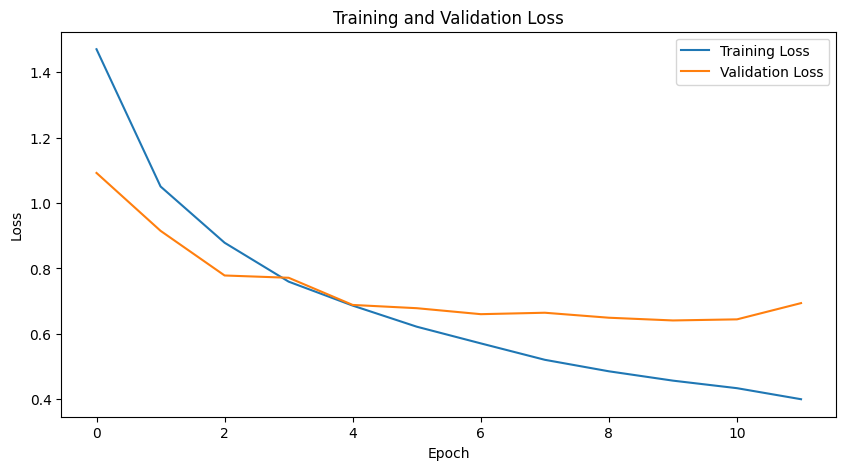

Test Accuracy: 78.17%


In [6]:
# Plot the training and validation loss
plt.figure(figsize=(10,5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# At the end of training, evaluate on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_accuracy = 100.0 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

## Implementing the LRP Explainability Method

####  LRP Implementation using Zennit:

In [106]:
from zennit.composites import EpsilonPlusFlat
from zennit.attribution import Gradient 

In [107]:
composite = EpsilonPlusFlat(epsilon=1e-6)

# Create an Attribution object
attr = Gradient(model, composite)

example_loader = DataLoader(test_set, batch_size=5, shuffle=True)
images, labels = next(iter(example_loader))
images, labels = images.cuda(), labels.cuda()

In [ ]:
output, attribution = attr(images)

model.eval()
with torch.no_grad():
    outputs = model(images)
_, predicted = outputs.max(1)

print("Predicted classes: ", [classes[p.item()] for p in predicted])


Predicted classes:  ['cat', 'deer', 'dog', 'truck', 'deer']


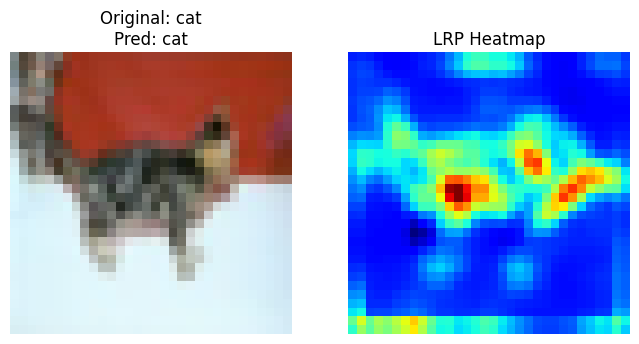

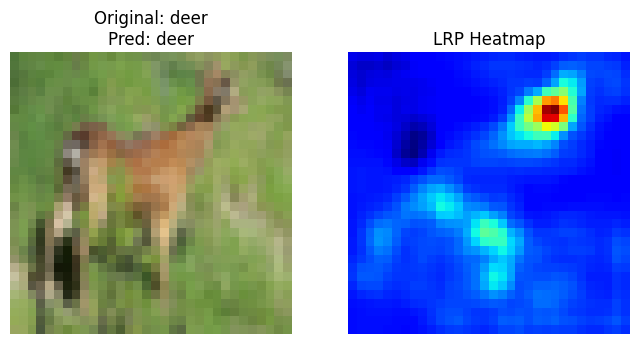

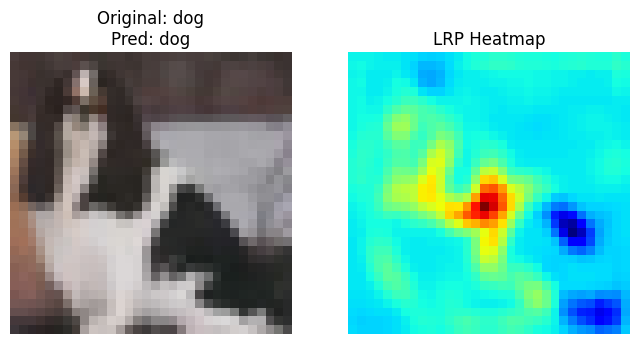

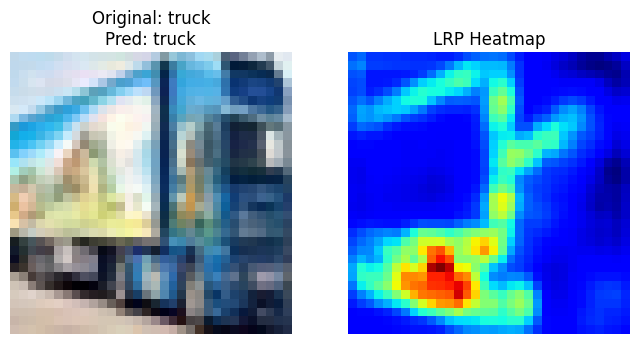

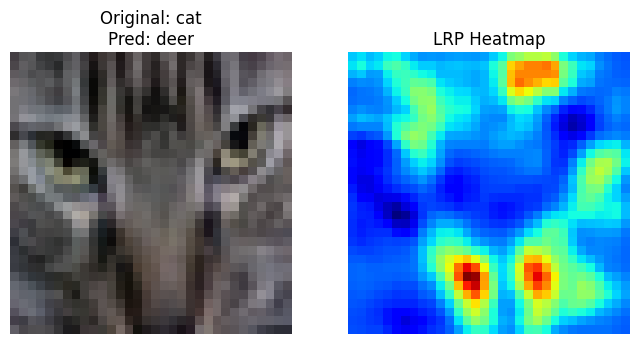

In [ ]:
# Define a function to create the attribution output based on the predicted classes
def attr_output_fn(output):
    one_hot = torch.zeros_like(output)
    one_hot[range(len(predicted)), predicted] = 1.0
    return one_hot


# Compute LRP attributions
# Pass the images and the custom attr_output_fn to the Gradient instance
output, relevance = attr(images, attr_output=attr_output_fn)

# relevance is a tensor with the same shape as `images` containing the relevance scores.
R = relevance.detach().cpu().numpy()

# Visualize the relevance maps as heatmaps
for i in range(len(images)):
    heatmap = R[i].sum(axis=0)
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-10)
    
    # Denormalize the original image for visualization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = images[i].detach().cpu().numpy()
    img = (img.transpose(1,2,0)*std + mean)
    img = np.clip(img,0,1)
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.title(f"Original: {classes[labels[i].item()]}\nPred: {classes[predicted[i].item()]}")
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.title("LRP Heatmap")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')
    plt.show()